In [1]:
#Problem Statement:Forecast the cocacola sales data set. Prepare a document for each model explaining 
how many dummy variables you have created and RMSE value for each model. Finally which model you will use for 
Forecasting.

In [1]:
import pandas as pd
import numpy as np
from datetime import  datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [2]:
df= pd.read_excel(r'E:\Data Science Course\Data Science Assignment\Forcasting\CocaCola_Sales_Rawdata.xlsx')

In [3]:
df.head(10)

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


In [4]:
df['Quarter'] = pd.to_datetime(df['Quarter'].str[-2:] + df['Quarter'].str[:2])

In [11]:
data = df.set_index(['Quarter'])

In [12]:
data.head(10)

,Sales
Quarter,
2086-01-01,1734.827000
2086-04-01,2244.960999
2086-07-01,2533.804993
2086-10-01,2154.962997
2087-01-01,1547.818996
2087-04-01,2104.411995
2087-07-01,2014.362999
2087-10-01,1991.746998
2088-01-01,1869.049999


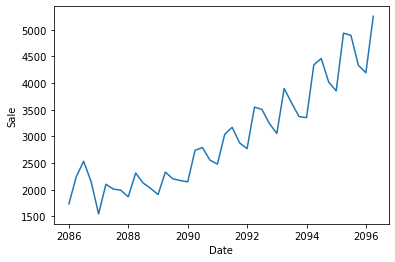

In [13]:
## plot graph
plt.xlabel('Date')
plt.ylabel('Sale')
plt.plot(data)

<AxesSubplot:ylabel='Sales'>

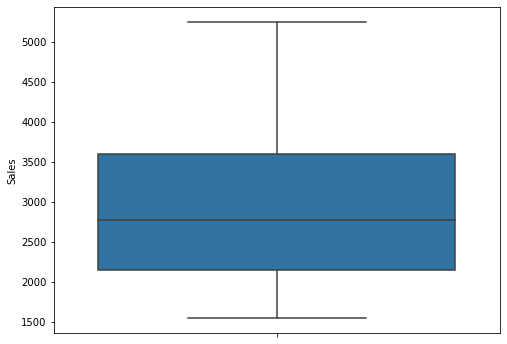

In [14]:
plt.figure(figsize=(8,6))

sns.boxplot(y="Sales",data=data)

array([[<AxesSubplot:title={'center':'Sales'}>]], dtype=object)

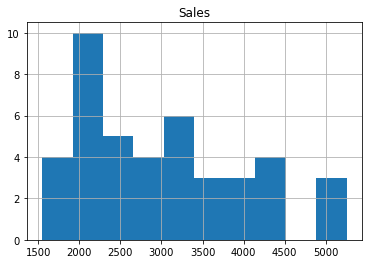

In [15]:
data.hist()

In [20]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

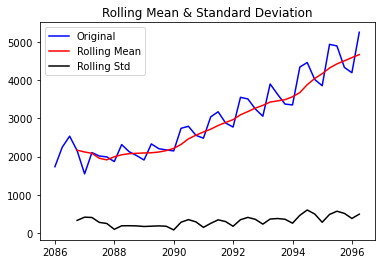

Results of Dickey Fuller Test:
Test Statistic                  1.309421
p-value                         0.996661
#Lags Used                      7.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


In [24]:
test_stationarity(data)

# trying differnt transformation

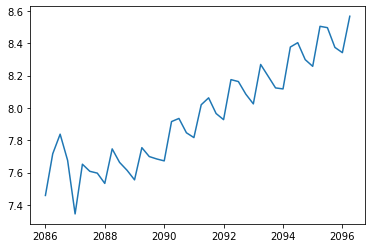

In [25]:
#Estimating trend
df_logScale = np.log(data)
plt.plot(df_logScale)

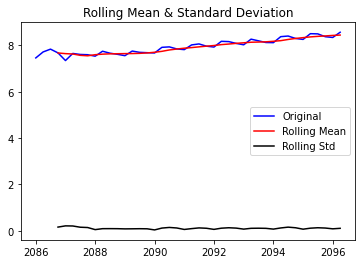

Results of Dickey Fuller Test:
Test Statistic                  0.192820
p-value                         0.971856
#Lags Used                      6.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


In [26]:
#check this log transfered data with function
test_stationarity(df_logScale)

In [27]:
import stat
df_sqroot = np.sqrt(data)  # applying the sq-root tranformation

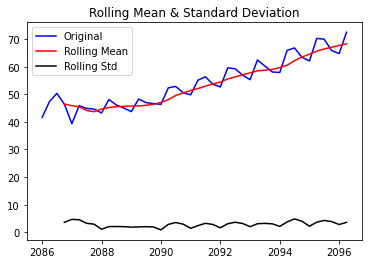

Results of Dickey Fuller Test:
Test Statistic                  0.828594
p-value                         0.992084
#Lags Used                      6.000000
Number of Observations Used    35.000000
Critical Value (1%)            -3.632743
Critical Value (5%)            -2.948510
Critical Value (10%)           -2.613017
dtype: float64


In [28]:
test_stationarity(df_sqroot)

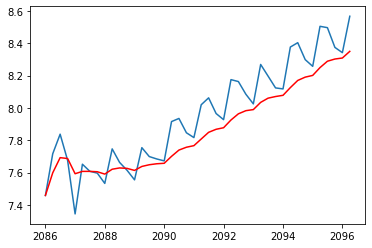

In [30]:
## exponentialDecayWeightedAverage
df_expDecayWA = df_logScale.ewm(halflife=4, min_periods=0, adjust=True).mean()
plt.plot(df_logScale)
plt.plot(df_expDecayWA, color='red')

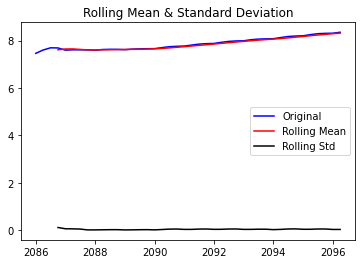

Results of Dickey Fuller Test:
Test Statistic                 -0.670273
p-value                         0.854300
#Lags Used                      9.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


In [31]:
test_stationarity(df_expDecayWA)

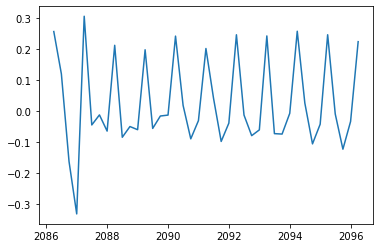

In [32]:
### df_logScale - df_logScale.shift()
df_LogDiffShifting = df_logScale - df_logScale.shift()
plt.plot(df_LogDiffShifting)

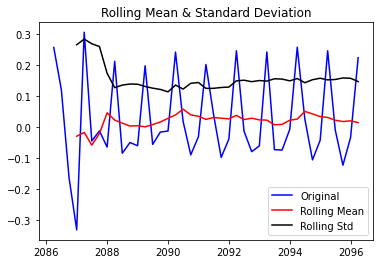

Results of Dickey Fuller Test:
Test Statistic                 -3.190392
p-value                         0.020548
#Lags Used                      6.000000
Number of Observations Used    34.000000
Critical Value (1%)            -3.639224
Critical Value (5%)            -2.951230
Critical Value (10%)           -2.614447
dtype: float64


In [33]:
df_LogDiffShifting.dropna(inplace= True)
test_stationarity(df_LogDiffShifting)

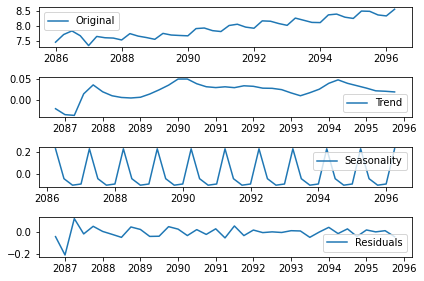

In [34]:
decomposition = seasonal_decompose(df_LogDiffShifting) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_logScale, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

#there can be cases where an observation simply consist of trend & seasonality. In that case, there won't be 
#any residual component & that would be a null or NaN. Hence, we also remove such cases.
#decomposedLogData = residual
#decomposedLogData.dropna(inplace=True)
#test_stationarity(decomposedLogData)

In [35]:
decomposedLogData = residual

In [36]:
decomposedLogData.dropna(inplace=True)

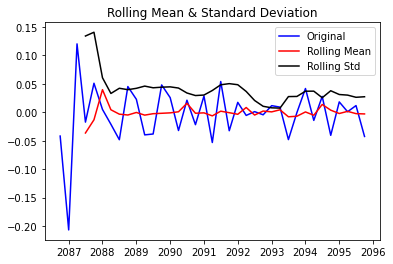

Results of Dickey Fuller Test:


KeyError: 'Sales'

In [37]:
test_stationarity(decomposedLogData)

# Plotting ACF & PACF

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


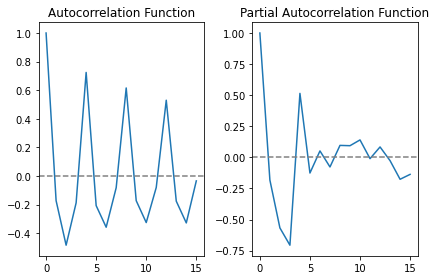

In [38]:
#ACF & PACF plots

lag_acf = acf(df_LogDiffShifting, nlags=15)
lag_pacf = pacf(df_LogDiffShifting, nlags=15, method='ols')
#%matplotlib
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
#plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
#plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
#plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
#plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()    

In [25]:
#q=1 and p=1

# Model building

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will

Plotting AR model


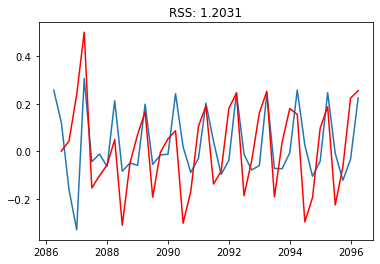

In [39]:
#ARIMA Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(df_LogDiffShifting, order=(2,1,2))
results_AR = model.fit(disp=-1)
plt.plot(df_LogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%((results_AR.fittedvalues - df_LogDiffShifting['Sales'])**2).sum())
print('Plotting AR model')

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warni

Plotting AR model


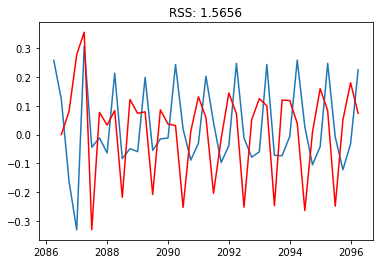

In [40]:
#ARIMA Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(df_LogDiffShifting, order=(1,1,1))
results_AR = model.fit(disp=-1)
plt.plot(df_LogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%((results_AR.fittedvalues - df_LogDiffShifting['Sales'])**2).sum())
print('Plotting AR model')

C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  warnings.warn('No frequency information was'
C:\Users\hp\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warni

Plotting AR model


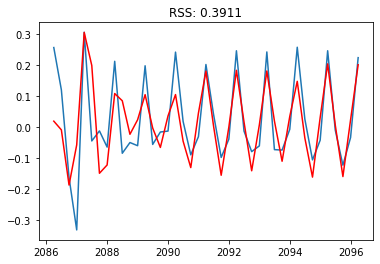

In [44]:

#ARIMA Model df_logScale

model = ARIMA(df_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(df_LogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%((results_ARIMA.fittedvalues - df_LogDiffShifting['Sales'])**2).sum())
print('Plotting AR model')

# Prediction

In [45]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Quarter
2086-04-01    0.020156
2086-07-01   -0.008016
2086-10-01   -0.186047
2087-01-01   -0.056375
2087-04-01    0.306659
dtype: float64


In [46]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Quarter
2086-04-01    0.020156
2086-07-01    0.012140
2086-10-01   -0.173907
2087-01-01   -0.230282
2087-04-01    0.076377
dtype: float64


In [47]:
df_logScale['Sales'].iloc[0]

7.458662975400341

In [48]:
predictions_ARIMA_log = pd.Series(df_logScale['Sales'].iloc[0], index=df_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

Quarter
2086-01-01    7.458663
2086-04-01    7.478819
2086-07-01    7.470803
2086-10-01    7.284756
2087-01-01    7.228381
dtype: float64

In [49]:
df_logScale.head()

,Sales
Quarter,
2086-01-01,7.458663
2086-04-01,7.716443
2086-07-01,7.837477
2086-10-01,7.675529
2087-01-01,7.344602


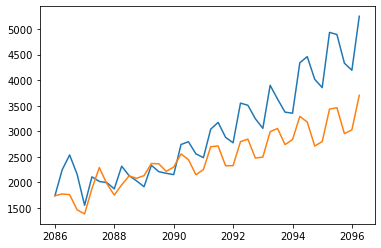

In [50]:
# Inverse of log is exp.
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)

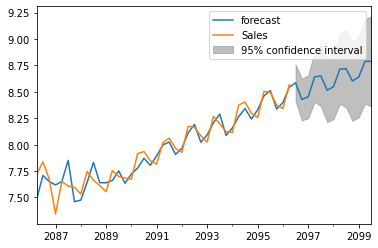

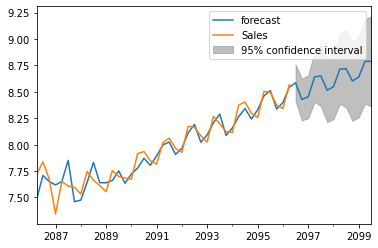

In [51]:
results_ARIMA.plot_predict(1,54) 

In [52]:
results_ARIMA.forecast(steps=12)[0]

array([8.58535019, 8.42760502, 8.45352434, 8.64048275, 8.65102197,
       8.51488662, 8.54800888, 8.71450621, 8.71880205, 8.60202557,
       8.64051852, 8.78871334])

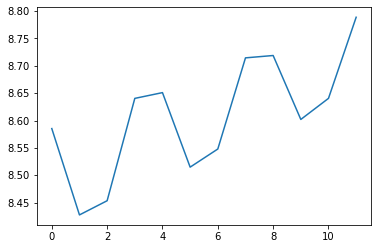

In [53]:
plt.plot(results_ARIMA.forecast(steps=12)[0])